# Parallel K-Means Clustering Algorithm on Spark

Author: **Giorgio Polla**  
Date: **21/11/2019**  

Implementation of the K-Means clustering algorithm on Spark, with Python.  
The algorithm is tested using the famous Iris dataset (available on Kaggle at https://www.kaggle.com/uciml/iris), and against Sklearn's implementation of K-Means.


In [1]:
import time
import pyspark
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import itemgetter
from sklearn import preprocessing
from sklearn.cluster import KMeans

FILE_PATH = '../data/iris'

In [2]:
sc = pyspark.SparkContext()

In [3]:
def read_file(file_path):
    rdd = sc.textFile(file_path)
    
    rdd = rdd.map(
        lambda x:
            x.split()
    )
    
    rdd_x = rdd.map(
        lambda x: 
            np.array([float(el) for el in x[:-1]])
    )
    
    rdd_y = rdd.map(
        lambda x:           
            x[-1]
    )
    return rdd_x, rdd_y

In [4]:
rdd_x, rdd_y = read_file(FILE_PATH)
rdd_x.first()

array([5.1, 3.5, 1.4, 0.2])

In [5]:
def standardise(rdd):    
    n_rows = rdd.count()
    
    col_sum = rdd.reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    mean = np.divide(col_sum, n_rows)
    
    variance = rdd.map(
        lambda x: np.square(x - mean)
    ).reduce(
        lambda x, y:
            [sum(el) for el in zip(x, y)]
    )
    std_dev = np.sqrt(np.divide(variance, n_rows))
    
    rdd = rdd.map(
        lambda x:
            np.divide((x - mean), std_dev)
    )
    
    return rdd

In [6]:
rdd_x = standardise(rdd_x)
rdd_x.first()

rdd_x.take(5)[1]

array([-1.14301691, -0.1249576 , -1.3412724 , -1.31297673])

In [7]:
def init_rdd(rdd):
    rdd = rdd.map(
        lambda x: (
            -1,
            x
        )
    )
    return rdd
    
    
def calc_distance(c, x):
    return np.linalg.norm(c - x)
    
    
def assign_cluster(centroids, x):
    distances = [calc_distance(c, x) for c in centroids]
    min_index = np.argmin(distances)    
    return min_index


def init_centroids(rdd, k, random):
    if random:
        return rdd.takeSample(False, k)
    return rdd.take(k)


def redefine_clusters(rdd, centroids):
    rdd = rdd.map(
        lambda x: (
            assign_cluster(centroids, x[1]),
            x[1]
        )
    )
    return rdd

    
def calculate_centroids(rdd):
    centroids = rdd.map(
        lambda x: (
            x[0], (
                x[1],
                1
            )
        )
    ).reduceByKey(
        lambda x, y: (
            x[0] + y[0],
            x[1] + y[1]
        )
    ).map(
        lambda x: [
            x[0],
            x[1][0] / x[1][1]
        ]
    ).collect()
    
    centroids = [el[1] for el in sorted(centroids, key=itemgetter(0))]
    return np.array(centroids)


def cluster_variance(rdd, centroids):
    variance = rdd.map(
        lambda x: 
            calc_distance(centroids[x[0]], x[1])
    ).reduce(
        lambda x, y:
            x + y
    )
    
    return variance    

In [24]:
def k_means(rdd_x, k, iterations=20, tolerance=0.001, 
            n_init=5, random_init=True, verbose=False):
    if k > rdd_x.count():
        print('Invalid K: too big!')
        return
    print('Starting: %d inits.' % n_init)
    y_arr = []
    cent_arr = []
    variance_arr = []
    
    if random_init == False:
        n_init = 1
    
    for trial in range(n_init):
        start_time = time.time()

        centroids = init_centroids(rdd_x, k, random=random_init)
        rdd = init_rdd(rdd_x)
        n_rows = rdd.count()
        for it in range(iterations):
            rdd = redefine_clusters(rdd, centroids)

            new_centroids = calculate_centroids(rdd)
            
            delta = np.linalg.norm(
                new_centroids - centroids[:len(new_centroids)]
            )
            
            if (delta < tolerance):
                print('%d. Converged.\t|\t' % (trial + 1), end='')
                break
            centroids = new_centroids

            if verbose and it % 5 == 0:
                print('It: %2d\t|\tDelta: %0.4f' % (it, delta))

        y = rdd.map(
            lambda x:
                x[0]
        ).collect()
        
        total_time = time.time() - start_time
        
        y_arr.append(y)
        cent_arr.append(centroids)
        variance_arr.append(cluster_variance(rdd, centroids))
        print('Variance: %0.2f\t|\tTime: %0.2fs' % 
              (variance_arr[-1], total_time)
        )
    
    index = np.argmin(variance_arr)
    y = y_arr[index]
    
    print('\nChosen init %d.' % (index + 1))
    [print('Cluster %d: %d' % (n, y.count(n))) \
        for n in sorted(np.unique(y))]
        
    return y, cent_arr[index]

In [25]:
y, ctrd = k_means(rdd_x, 3, random_init=True)

Starting: 5 inits.
1. Converged.	|	Variance: 129.95	|	Time: 1.68s
2. Converged.	|	Variance: 149.03	|	Time: 0.90s
3. Converged.	|	Variance: 129.62	|	Time: 1.81s
4. Converged.	|	Variance: 129.89	|	Time: 1.66s
5. Converged.	|	Variance: 149.03	|	Time: 0.82s

Chosen init 3.
Cluster 0: 53
Cluster 1: 50
Cluster 2: 47


### Sklearn K-Means
Comparison with the results obtained by the K-Means implementation available in the Sklearn library.

0: 47, 1: 50, 2: 53


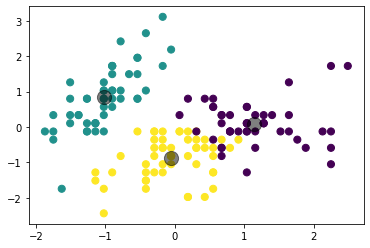

In [26]:
df = pd.read_csv(FILE_PATH + '.csv').iloc[:,:-1]
x = df.values
standard_scaler = preprocessing.StandardScaler()
x = standard_scaler.fit_transform(x)

km = KMeans(n_clusters=3)
km.fit(x)
y_kmeans = km.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')
ys = list(y_kmeans)
print('0: %2d, 1: %2d, 2: %2d' % (ys.count(0), ys.count(1), ys.count(2)))

centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

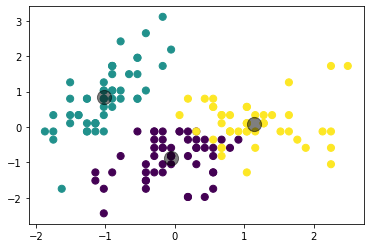

In [27]:
plt.scatter(x[:, 0], x[:, 1], c=y, s=50, cmap='viridis')

plt.scatter(ctrd[:, 0], ctrd[:, 1], c='black', s=200, alpha=0.5);

As shown by the plotted graphs, the results obtained are very similar.  
The centroid are almost in the same exact positions.

In [28]:

centr_sklearn = np.array(sorted(centers, key=itemgetter(0)))
centr_this = np.array(sorted(ctrd, key=itemgetter(0)))
                       
print('Total centroid error: %0.4f' %
       np.sum(abs(centr_this - centr_sklearn)))

y1 = y[:50]
y2 = y[50:100]
y3 = y[100:]
print(y1.count(2))
print(y2.count(0))
print(y3.count(1))

acc = (y1.count(2) + y2.count(0) + y3.count(1)) / 150
print(acc)

Total centroid error: 0.0000
0
39
0
0.26
